# EV Battery Health Prediction - Model Training and Evaluation

This notebook trains and evaluates multiple regression models to predict battery health (RUL - Remaining Useful Life).

## Objectives
1. Import and preprocess the cleaned EV battery dataset
2. Split data into training and testing sets
3. Select suitable features for battery health prediction
4. Train multiple regression models (Linear Regression, Random Forest, XGBoost)
5. Evaluate models using MAE, MSE, RMSE, and R² scores
6. Select the best model and save it
7. Visualize actual vs predicted values


## 1. Import Required Libraries


In [2]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import sklearn
import xgboost as xgb
import joblib

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✓ All libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")
print(f"XGBoost version: {xgb.__version__}")


✓ All libraries imported successfully!
Pandas version: 2.3.3
NumPy version: 2.3.4
Scikit-learn version: 1.7.2
XGBoost version: 3.1.1


## 2. Load the Dataset


In [3]:
# Load the merged dataset
print("Loading dataset...")
print("=" * 80)

# Try to load merged dataset first, if not available, use cleaned dataset
try:
    df = pd.read_csv('data/merged_battery_data.csv')
    print(f"✓ Loaded merged_battery_data.csv - Shape: {df.shape}")
except FileNotFoundError:
    try:
        df = pd.read_csv('data/cleaned_battery_data.csv')
        print(f"✓ Loaded cleaned_battery_data.csv - Shape: {df.shape}")
    except FileNotFoundError:
        raise FileNotFoundError("Could not find dataset. Please ensure merged_battery_data.csv or cleaned_battery_data.csv exists in the data/ folder.")

print(f"\nDataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"\nFirst few rows:")
display(df.head())
print(f"\nDataset info:")
print(df.info())
print(f"\nMissing values:")
print(df.isnull().sum())


Loading dataset...
✓ Loaded merged_battery_data.csv - Shape: (15064, 14)

Dataset shape: (15064, 14)
Columns: ['Cycle_Index', 'Discharge Time (s)', 'Decrement 3.6-3.4V (s)', 'Max. Voltage Dischar. (V)', 'Min. Voltage Charg. (V)', 'Time at 4.15V (s)', 'Time constant current (s)', 'Charging time (s)', 'RUL', 'Exp_Time', 'Exp_Current', 'Exp_Voltage', 'Exp_Temperature', 'Exp_Cell_Type']

First few rows:


,Cycle_Index,Discharge Time (s),Decrement 3.6-3.4V (s),Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),Time constant current (s),Charging time (s),RUL,Exp_Time,Exp_Current,Exp_Voltage,Exp_Temperature,Exp_Cell_Type
0,1.0,2595.30,1151.488500,3.670,3.211,5460.001,6755.01,10777.82,1112,0.000000,2.158704,2.999607,26.384377,Fresh
1,2.0,7408.64,1172.512500,4.246,3.220,5508.992,6762.02,10500.35,1111,1.000000,2.287674,2.999407,26.227879,Fresh
2,3.0,7393.76,1112.992000,4.249,3.224,5508.993,6762.02,10420.38,1110,2.000000,2.228280,2.999757,26.449251,Fresh
3,4.0,7385.50,1080.320667,4.250,3.225,5502.016,6762.02,10322.81,1109,2.999992,2.224886,2.999857,26.277494,Fresh
4,6.0,65022.75,29813.487000,4.290,3.398,5480.992,53213.54,56699.65,1107,4.000000,2.134946,2.999958,26.380539,Fresh



Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15064 entries, 0 to 15063
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Cycle_Index                15064 non-null  float64
 1   Discharge Time (s)         15064 non-null  float64
 2   Decrement 3.6-3.4V (s)     15064 non-null  float64
 3   Max. Voltage Dischar. (V)  15064 non-null  float64
 4   Min. Voltage Charg. (V)    15064 non-null  float64
 5   Time at 4.15V (s)          15064 non-null  float64
 6   Time constant current (s)  15064 non-null  float64
 7   Charging time (s)          15064 non-null  float64
 8   RUL                        15064 non-null  int64  
 9   Exp_Time                   15064 non-null  float64
 10  Exp_Current                15064 non-null  float64
 11  Exp_Voltage                15064 non-null  float64
 12  Exp_Temperature            15064 non-null  float64
 13  Exp_Cell_Type              1506

## 3. Data Preprocessing and Feature Selection


In [4]:
print("=" * 80)
print("DATA PREPROCESSING AND FEATURE SELECTION")
print("=" * 80)

# Define target variable (RUL - Remaining Useful Life)
target = 'RUL'

# Check if target exists
if target not in df.columns:
    raise ValueError(f"Target variable '{target}' not found in dataset. Available columns: {list(df.columns)}")

print(f"\nTarget variable: {target}")
print(f"Target statistics:")
print(df[target].describe())

# Select features for modeling
# Exclude non-numeric columns and target variable
exclude_cols = [target, 'Exp_Cell_Type']  # Exclude target and categorical columns
feature_cols = [col for col in df.columns if col not in exclude_cols and df[col].dtype in [np.int64, np.float64]]

print(f"\nSelected features ({len(feature_cols)}):")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i}. {col}")

# Handle missing values
print(f"\nHandling missing values...")
initial_missing = df[feature_cols + [target]].isnull().sum().sum()
if initial_missing > 0:
    # Fill numeric columns with median
    for col in feature_cols:
        df[col].fillna(df[col].median(), inplace=True)
    df[target].fillna(df[target].median(), inplace=True)
    print(f"✓ Filled {initial_missing} missing values")
else:
    print("✓ No missing values found")

# Prepare X and y
X = df[feature_cols].copy()
y = df[target].copy()

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"\nFeature statistics:")
display(X.describe())


DATA PREPROCESSING AND FEATURE SELECTION

Target variable: RUL
Target statistics:
count    15064.000000
mean       554.194172
std        322.434514
min          0.000000
25%        277.000000
50%        551.000000
75%        839.000000
max       1133.000000
Name: RUL, dtype: float64

Selected features (12):
  1. Cycle_Index
  2. Discharge Time (s)
  3. Decrement 3.6-3.4V (s)
  4. Max. Voltage Dischar. (V)
  5. Min. Voltage Charg. (V)
  6. Time at 4.15V (s)
  7. Time constant current (s)
  8. Charging time (s)
  9. Exp_Time
  10. Exp_Current
  11. Exp_Voltage
  12. Exp_Temperature

Handling missing values...
✓ No missing values found

Feature matrix shape: (15064, 12)
Target vector shape: (15064,)

Feature statistics:


,Cycle_Index,Discharge Time (s),Decrement 3.6-3.4V (s),Max. Voltage Dischar. (V),Min. Voltage Charg. (V),Time at 4.15V (s),Time constant current (s),Charging time (s),Exp_Time,Exp_Current,Exp_Voltage,Exp_Temperature
count,15064.000000,15064.000000,15064.000000,15064.000000,15064.000000,15064.000000,15064.000000,15064.000000,15064.000000,15064.000000,15064.000000,15064.000000
mean,556.155005,4581.273960,1239.784672,3.908176,3.577904,3768.336171,5461.266970,10066.496204,7531.500000,-0.185586,3.793072,25.846019
std,322.378480,33144.012077,15039.589269,0.091003,0.123695,9129.552477,25155.845202,26415.354121,4348.746563,19.244747,0.267578,0.267029
min,1.000000,8.690000,-397645.908000,3.043000,3.022000,-113.584000,5.980000,5.980000,0.000000,-20.066510,2.999006,25.201105
25%,271.000000,1169.310000,319.600000,3.846000,3.488000,1828.884179,2564.310000,7841.922500,3765.750000,-19.954510,3.606199,25.640059
50%,560.000000,1557.250000,439.239471,3.906000,3.574000,2930.203500,3824.260000,8320.415000,7531.500000,-4.068327,3.794914,25.811815
75%,833.000000,1908.000000,600.000000,3.972000,3.663000,4088.326500,5012.350000,8763.282500,11297.250004,20.056646,4.000772,26.029396
max,1134.000000,958320.370000,406703.768000,4.363000,4.379000,245101.117000,880728.100000,880728.100000,15063.000000,20.326465,4.200569,27.113413


## 4. Split Data into Training and Testing Sets


In [5]:
# Split the data into training and testing sets
# Using 80% for training and 20% for testing
test_size = 0.2
random_state = 42

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=random_state, shuffle=True
)

print("=" * 80)
print("DATA SPLITTING")
print("=" * 80)
print(f"\nTraining set:")
print(f"  X_train shape: {X_train.shape}")
print(f"  y_train shape: {y_train.shape}")
print(f"  y_train range: [{y_train.min():.2f}, {y_train.max():.2f}]")
print(f"  y_train mean: {y_train.mean():.2f}")

print(f"\nTesting set:")
print(f"  X_test shape: {X_test.shape}")
print(f"  y_test shape: {y_test.shape}")
print(f"  y_test range: [{y_test.min():.2f}, {y_test.max():.2f}]")
print(f"  y_test mean: {y_test.mean():.2f}")

print(f"\nSplit ratio: {100*(1-test_size):.0f}% training, {100*test_size:.0f}% testing")


DATA SPLITTING

Training set:
  X_train shape: (12051, 12)
  y_train shape: (12051,)
  y_train range: [0.00, 1132.00]
  y_train mean: 555.76

Testing set:
  X_test shape: (3013, 12)
  y_test shape: (3013,)
  y_test range: [0.00, 1133.00]
  y_test mean: 547.95

Split ratio: 80% training, 20% testing


## 5. Feature Scaling


In [6]:
# Scale features using StandardScaler
# Important: Fit on training data only, then transform both train and test
print("=" * 80)
print("FEATURE SCALING")
print("=" * 80)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for better readability
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_cols, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_cols, index=X_test.index)

print("\n✓ Features scaled using StandardScaler")
print(f"  Training set - Mean: {X_train_scaled.mean().abs().mean():.6f} (should be ~0)")
print(f"  Training set - Std: {X_train_scaled.std().mean():.6f} (should be ~1)")
print(f"  Test set scaled successfully")

# Update X_train and X_test to scaled versions
X_train = X_train_scaled
X_test = X_test_scaled


FEATURE SCALING

✓ Features scaled using StandardScaler
  Training set - Mean: 0.000000 (should be ~0)
  Training set - Std: 1.000041 (should be ~1)
  Test set scaled successfully


## 6. Train Multiple Regression Models


In [7]:
print("=" * 80)
print("TRAINING REGRESSION MODELS")
print("=" * 80)

# Dictionary to store models
models = {}

# 1. Linear Regression
print("\n1. Training Linear Regression...")
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
models['Linear Regression'] = lr_model
print("   ✓ Linear Regression trained")

# 2. Random Forest Regressor
print("\n2. Training Random Forest Regressor...")
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=random_state,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
models['Random Forest'] = rf_model
print("   ✓ Random Forest Regressor trained")

# 3. XGBoost Regressor
print("\n3. Training XGBoost Regressor...")
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=random_state,
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)
models['XGBoost'] = xgb_model
print("   ✓ XGBoost Regressor trained")

print(f"\n✓ All {len(models)} models trained successfully!")


TRAINING REGRESSION MODELS

1. Training Linear Regression...
   ✓ Linear Regression trained

2. Training Random Forest Regressor...
   ✓ Random Forest Regressor trained

3. Training XGBoost Regressor...
   ✓ XGBoost Regressor trained

✓ All 3 models trained successfully!


## 7. Evaluate Models


In [8]:
print("=" * 80)
print("MODEL EVALUATION")
print("=" * 80)

# Function to calculate all metrics
def evaluate_model(y_true, y_pred, model_name):
    """Calculate MAE, MSE, RMSE, and R² score"""
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {
        'Model': model_name,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R²': r2
    }

# Evaluate all models
results = []

for model_name, model in models.items():
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate on training set
    train_metrics = evaluate_model(y_train, y_train_pred, f"{model_name} (Train)")
    train_metrics['Set'] = 'Train'
    
    # Evaluate on test set
    test_metrics = evaluate_model(y_test, y_test_pred, f"{model_name} (Test)")
    test_metrics['Set'] = 'Test'
    
    results.append(train_metrics)
    results.append(test_metrics)
    
    print(f"\n{model_name}:")
    print(f"  Training - MAE: {train_metrics['MAE']:.4f}, RMSE: {train_metrics['RMSE']:.4f}, R²: {train_metrics['R²']:.4f}")
    print(f"  Testing  - MAE: {test_metrics['MAE']:.4f}, RMSE: {test_metrics['RMSE']:.4f}, R²: {test_metrics['R²']:.4f}")

# Create results DataFrame
results_df = pd.DataFrame(results)

# Display results table
print("\n" + "=" * 80)
print("COMPREHENSIVE EVALUATION RESULTS")
print("=" * 80)
display(results_df.pivot(index='Model', columns='Set', values=['MAE', 'MSE', 'RMSE', 'R²']))


MODEL EVALUATION

Linear Regression:
  Training - MAE: 4.4300, RMSE: 6.4422, R²: 0.9996
  Testing  - MAE: 4.5823, RMSE: 6.6813, R²: 0.9996

Random Forest:
  Training - MAE: 0.7868, RMSE: 1.4599, R²: 1.0000
  Testing  - MAE: 1.7724, RMSE: 3.2175, R²: 0.9999

XGBoost:
  Training - MAE: 1.0833, RMSE: 1.3476, R²: 1.0000
  Testing  - MAE: 1.2786, RMSE: 1.6488, R²: 1.0000

COMPREHENSIVE EVALUATION RESULTS


MAE                  MSE                 RMSE  \
Set                            Test     Train       Test      Train      Test   
Model                                                                           
Linear Regression (Test)   4.582279       NaN  44.639126        NaN  6.681252   
Linear Regression (Train)       NaN  4.429971        NaN  41.501361       NaN   
Random Forest (Test)       1.772379       NaN  10.352497        NaN  3.217530   
Random Forest (Train)           NaN  0.786850        NaN   2.131273       NaN   
XGBoost (Test)             1.278606       NaN   2.718688        NaN  1.648845   
XGBoost (Train)                 NaN  1.083253        NaN   1.816110       NaN   

                                           R²            
Set                           Train      Test     Train  
Model                                                    
Linear Regression (Test)        NaN  0.999569       NaN  
Linear Regression (Train)  6.442155       NaN  0.999601  
Random Forest (Test)            NaN  0.999900       NaN  
Random Forest (Train)      1.459888       NaN  0.999980  
XGBoost (Test)                  NaN  0.999974       NaN  
XGBoost (Train)            1.347631       NaN  0.999983

## 8. Compare Models and Select Best Model


In [9]:
# Compare models based on test set performance
print("=" * 80)
print("MODEL COMPARISON")
print("=" * 80)

# Get test set results only
test_results = results_df[results_df['Set'] == 'Test'].copy()

# Remove ' (Test)' suffix for cleaner display
test_results['Model'] = test_results['Model'].str.replace(' (Test)', '', regex=False)

# Sort by R² score (higher is better)
test_results_sorted = test_results.sort_values('R²', ascending=False)

print("\nTest Set Performance (sorted by R² score):")
print("-" * 80)
display(test_results_sorted[['Model', 'MAE', 'MSE', 'RMSE', 'R²']])

# Select best model based on R² score (can also use RMSE or MAE)
best_model_name = test_results_sorted.iloc[0]['Model']
best_model = models[best_model_name]

print(f"\n{'='*80}")
print(f"BEST MODEL SELECTED: {best_model_name}")
print(f"{'='*80}")
best_metrics = test_results_sorted.iloc[0]
print(f"  MAE:  {best_metrics['MAE']:.4f}")
print(f"  MSE:  {best_metrics['MSE']:.4f}")
print(f"  RMSE: {best_metrics['RMSE']:.4f}")
print(f"  R²:   {best_metrics['R²']:.4f}")

# Store predictions for visualization
y_test_pred_best = best_model.predict(X_test)
y_train_pred_best = best_model.predict(X_train)


MODEL COMPARISON

Test Set Performance (sorted by R² score):
--------------------------------------------------------------------------------


,Model,MAE,MSE,RMSE,R²
5,XGBoost,1.278606,2.718688,1.648845,0.999974
3,Random Forest,1.772379,10.352497,3.217530,0.999900
1,Linear Regression,4.582279,44.639126,6.681252,0.999569



BEST MODEL SELECTED: XGBoost
  MAE:  1.2786
  MSE:  2.7187
  RMSE: 1.6488
  R²:   1.0000


## 9. Save the Best Model


In [10]:
# Save the best model and scaler
print("=" * 80)
print("SAVING MODEL")
print("=" * 80)

model_filename = 'battery_health_model.pkl'
scaler_filename = 'feature_scaler.pkl'

# Save the model
joblib.dump(best_model, model_filename)
print(f"✓ Model saved as: {model_filename}")

# Save the scaler (important for future predictions)
joblib.dump(scaler, scaler_filename)
print(f"✓ Scaler saved as: {scaler_filename}")

# Also save feature names for reference
import json
feature_info = {
    'feature_names': feature_cols,
    'target_name': target,
    'model_name': best_model_name,
    'model_metrics': {
        'MAE': float(best_metrics['MAE']),
        'MSE': float(best_metrics['MSE']),
        'RMSE': float(best_metrics['RMSE']),
        'R²': float(best_metrics['R²'])
    }
}

with open('model_info.json', 'w') as f:
    json.dump(feature_info, f, indent=2)

print(f"✓ Model info saved as: model_info.json")

print(f"\n✓ All files saved successfully!")
print(f"  - Model: {model_filename}")
print(f"  - Scaler: {scaler_filename}")
print(f"  - Info: model_info.json")


SAVING MODEL
✓ Model saved as: battery_health_model.pkl
✓ Scaler saved as: feature_scaler.pkl
✓ Model info saved as: model_info.json

✓ All files saved successfully!
  - Model: battery_health_model.pkl
  - Scaler: feature_scaler.pkl
  - Info: model_info.json


## 10. Visualizations - Actual vs Predicted Values


CREATING VISUALIZATIONS
✓ Saved: actual_vs_predicted_all_models.png


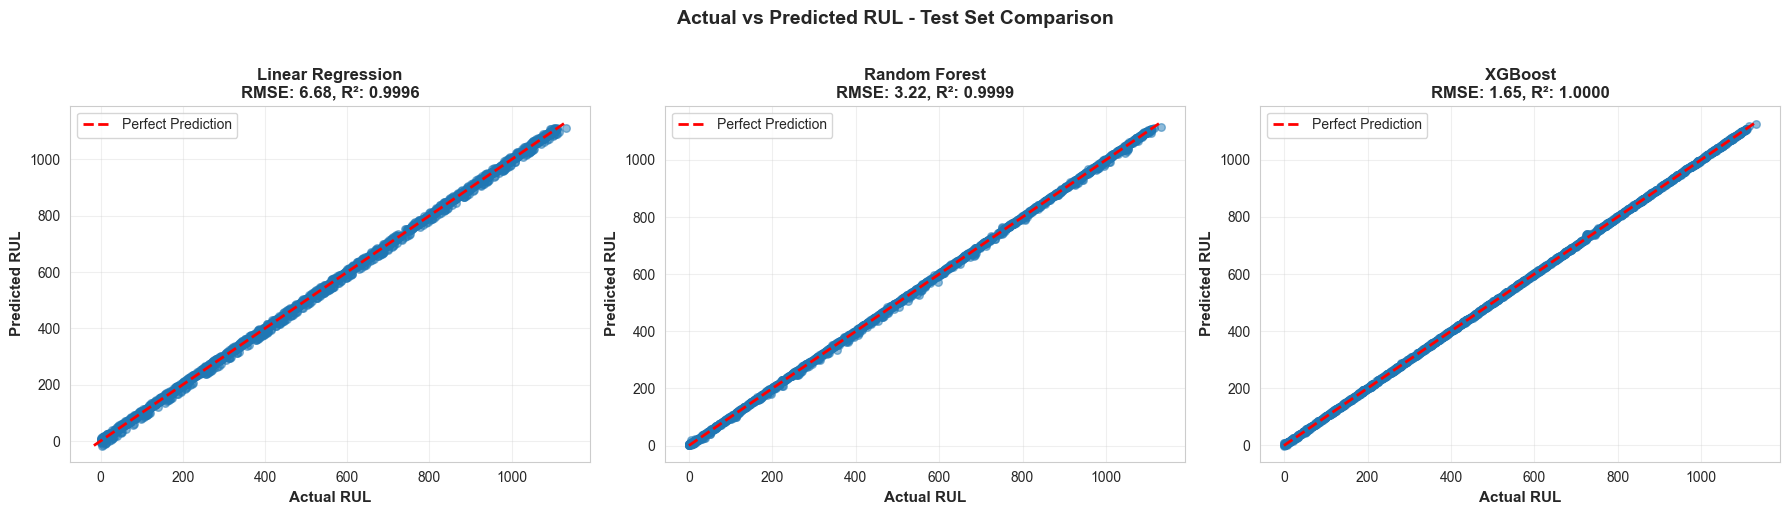

In [11]:
# Create visualizations for all models
print("=" * 80)
print("CREATING VISUALIZATIONS")
print("=" * 80)

# 1. Actual vs Predicted for all models (Test Set)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, (model_name, model) in enumerate(models.items()):
    ax = axes[idx]
    y_pred = model.predict(X_test)
    
    # Scatter plot
    ax.scatter(y_test, y_pred, alpha=0.5, s=30)
    
    # Perfect prediction line (y=x)
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    
    # Calculate metrics for this model
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    ax.set_xlabel('Actual RUL', fontsize=11, fontweight='bold')
    ax.set_ylabel('Predicted RUL', fontsize=11, fontweight='bold')
    ax.set_title(f'{model_name}\nRMSE: {rmse:.2f}, R²: {r2:.4f}', fontsize=12, fontweight='bold')
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

plt.suptitle('Actual vs Predicted RUL - Test Set Comparison', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('actual_vs_predicted_all_models.png', dpi=300, bbox_inches='tight')
print("✓ Saved: actual_vs_predicted_all_models.png")
plt.show()


✓ Saved: best_model_detailed_analysis.png


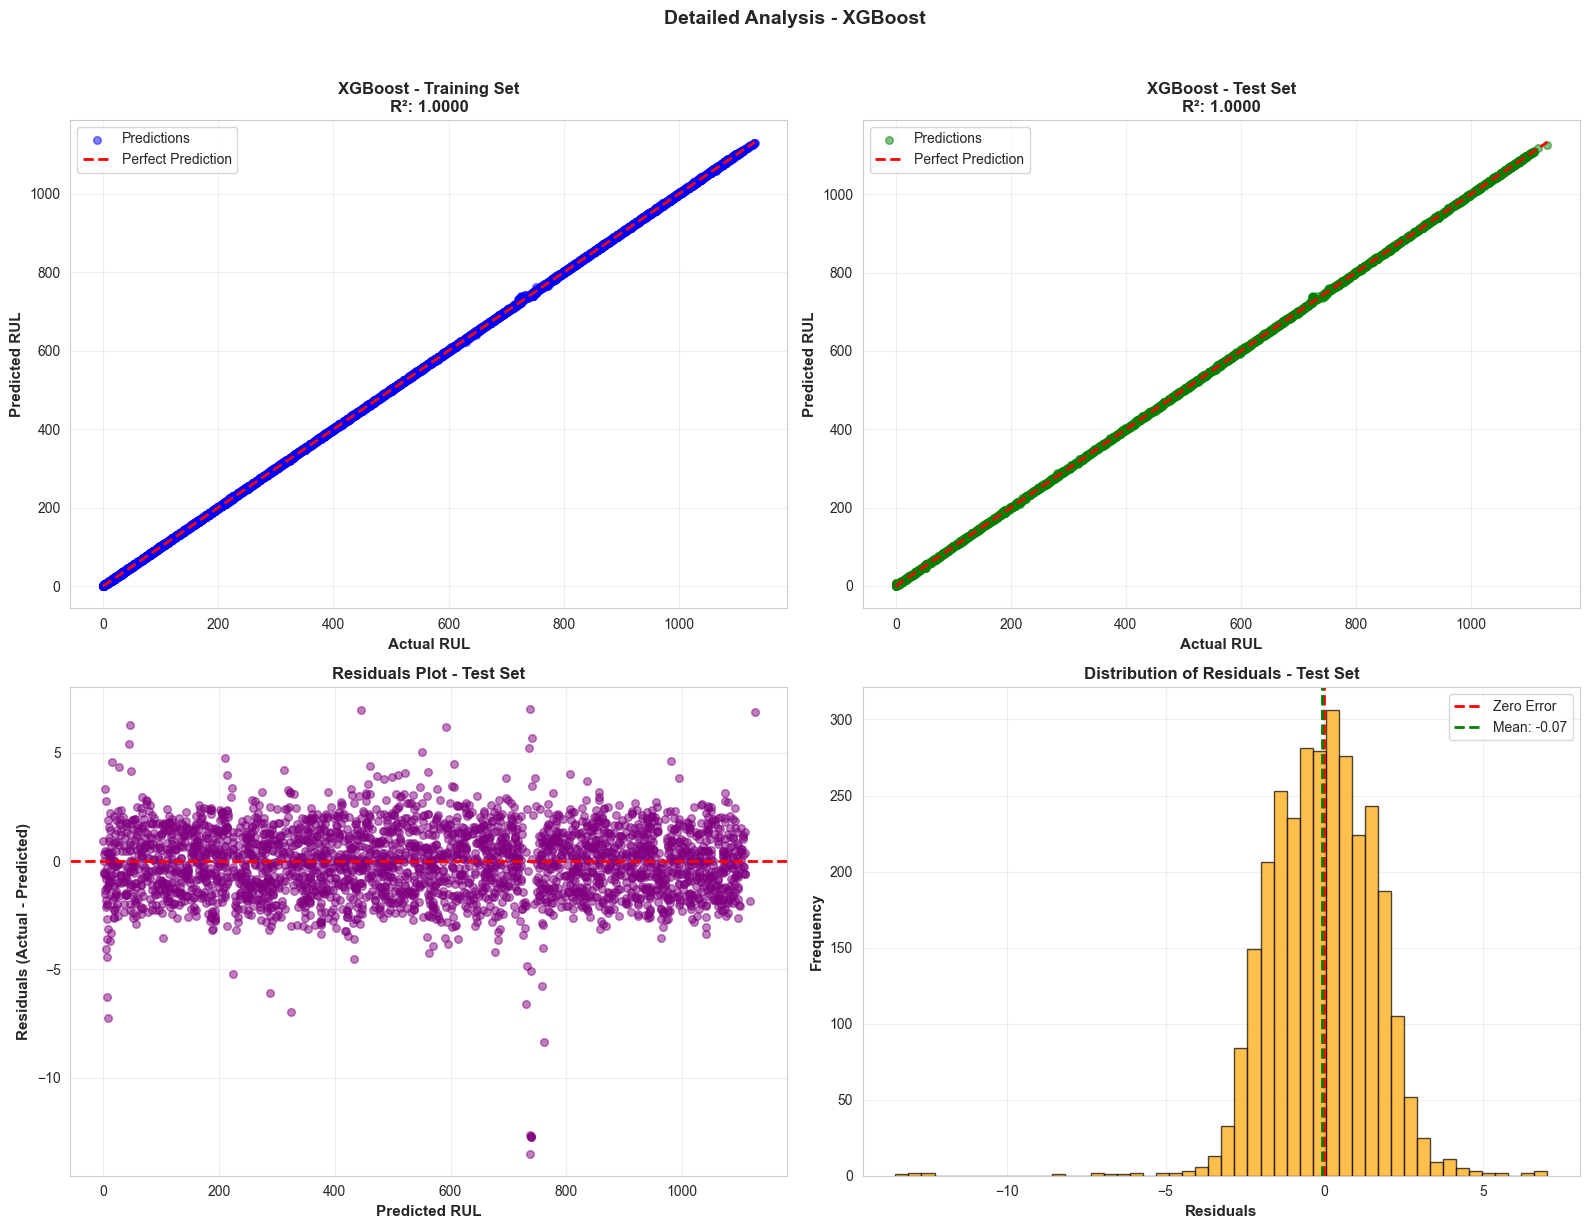

In [12]:
# 2. Detailed visualization for the best model
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 2.1 Training set - Actual vs Predicted
ax1 = axes[0, 0]
ax1.scatter(y_train, y_train_pred_best, alpha=0.5, s=30, color='blue', label='Predictions')
min_val_train = min(y_train.min(), y_train_pred_best.min())
max_val_train = max(y_train.max(), y_train_pred_best.max())
ax1.plot([min_val_train, max_val_train], [min_val_train, max_val_train], 'r--', lw=2, label='Perfect Prediction')
ax1.set_xlabel('Actual RUL', fontsize=11, fontweight='bold')
ax1.set_ylabel('Predicted RUL', fontsize=11, fontweight='bold')
ax1.set_title(f'{best_model_name} - Training Set\nR²: {r2_score(y_train, y_train_pred_best):.4f}', 
              fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2.2 Test set - Actual vs Predicted
ax2 = axes[0, 1]
ax2.scatter(y_test, y_test_pred_best, alpha=0.5, s=30, color='green', label='Predictions')
min_val_test = min(y_test.min(), y_test_pred_best.min())
max_val_test = max(y_test.max(), y_test_pred_best.max())
ax2.plot([min_val_test, max_val_test], [min_val_test, max_val_test], 'r--', lw=2, label='Perfect Prediction')
ax2.set_xlabel('Actual RUL', fontsize=11, fontweight='bold')
ax2.set_ylabel('Predicted RUL', fontsize=11, fontweight='bold')
ax2.set_title(f'{best_model_name} - Test Set\nR²: {best_metrics["R²"]:.4f}', 
              fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 2.3 Residuals plot (Test set)
ax3 = axes[1, 0]
residuals = y_test - y_test_pred_best
ax3.scatter(y_test_pred_best, residuals, alpha=0.5, s=30, color='purple')
ax3.axhline(y=0, color='r', linestyle='--', lw=2)
ax3.set_xlabel('Predicted RUL', fontsize=11, fontweight='bold')
ax3.set_ylabel('Residuals (Actual - Predicted)', fontsize=11, fontweight='bold')
ax3.set_title('Residuals Plot - Test Set', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)

# 2.4 Distribution of residuals
ax4 = axes[1, 1]
ax4.hist(residuals, bins=50, alpha=0.7, color='orange', edgecolor='black')
ax4.axvline(x=0, color='r', linestyle='--', lw=2, label='Zero Error')
ax4.axvline(x=residuals.mean(), color='g', linestyle='--', lw=2, 
            label=f'Mean: {residuals.mean():.2f}')
ax4.set_xlabel('Residuals', fontsize=11, fontweight='bold')
ax4.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax4.set_title('Distribution of Residuals - Test Set', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.suptitle(f'Detailed Analysis - {best_model_name}', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('best_model_detailed_analysis.png', dpi=300, bbox_inches='tight')
print("✓ Saved: best_model_detailed_analysis.png")
plt.show()


✓ Saved: model_comparison_metrics.png


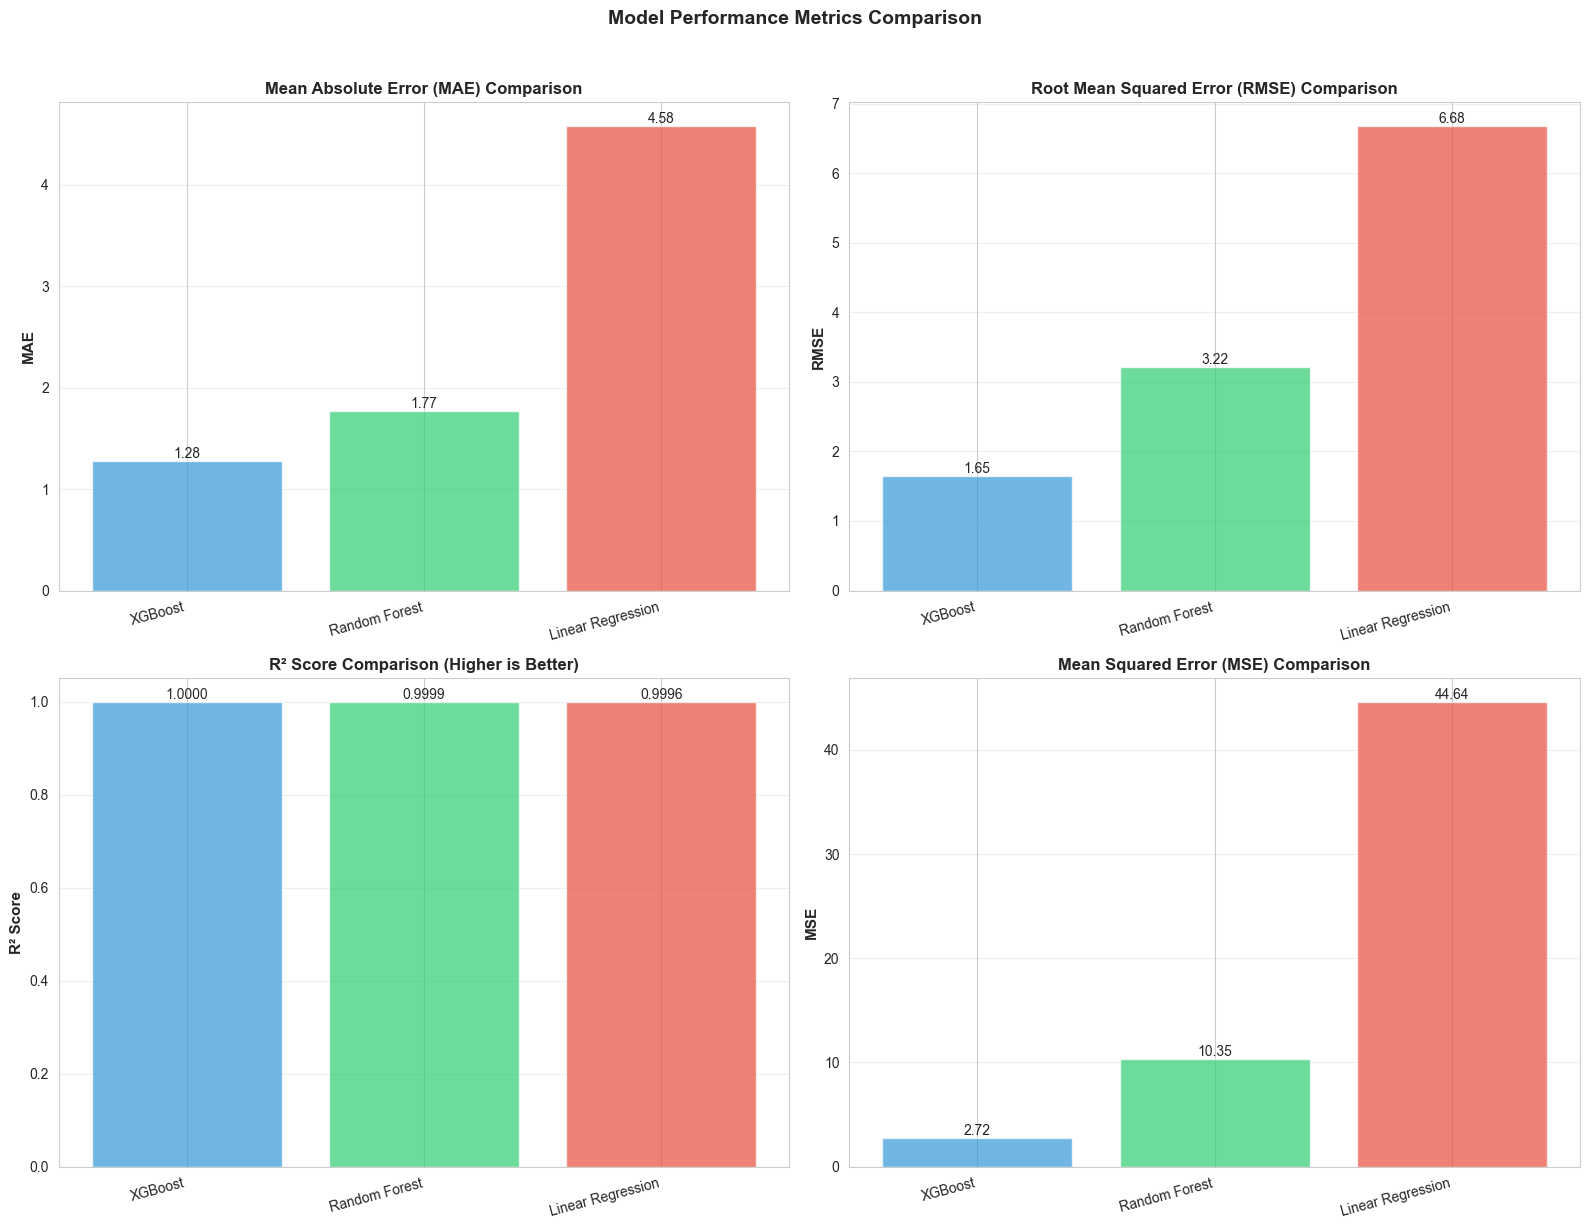

In [13]:
# 3. Model comparison bar chart
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Extract test metrics for each model
model_names_clean = [name.replace(' (Test)', '') for name in test_results_sorted['Model']]
mae_scores = test_results_sorted['MAE'].values
rmse_scores = test_results_sorted['RMSE'].values
r2_scores = test_results_sorted['R²'].values
mse_scores = test_results_sorted['MSE'].values

# 3.1 MAE Comparison
ax1 = axes[0, 0]
bars1 = ax1.bar(model_names_clean, mae_scores, color=['#3498db', '#2ecc71', '#e74c3c'], alpha=0.7)
ax1.set_ylabel('MAE', fontsize=11, fontweight='bold')
ax1.set_title('Mean Absolute Error (MAE) Comparison', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
for bar, score in zip(bars1, mae_scores):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{score:.2f}', ha='center', va='bottom', fontsize=10)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=15, ha='right')

# 3.2 RMSE Comparison
ax2 = axes[0, 1]
bars2 = ax2.bar(model_names_clean, rmse_scores, color=['#3498db', '#2ecc71', '#e74c3c'], alpha=0.7)
ax2.set_ylabel('RMSE', fontsize=11, fontweight='bold')
ax2.set_title('Root Mean Squared Error (RMSE) Comparison', fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
for bar, score in zip(bars2, rmse_scores):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{score:.2f}', ha='center', va='bottom', fontsize=10)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=15, ha='right')

# 3.3 R² Comparison
ax3 = axes[1, 0]
bars3 = ax3.bar(model_names_clean, r2_scores, color=['#3498db', '#2ecc71', '#e74c3c'], alpha=0.7)
ax3.set_ylabel('R² Score', fontsize=11, fontweight='bold')
ax3.set_title('R² Score Comparison (Higher is Better)', fontsize=12, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)
for bar, score in zip(bars3, r2_scores):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{score:.4f}', ha='center', va='bottom', fontsize=10)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=15, ha='right')

# 3.4 MSE Comparison
ax4 = axes[1, 1]
bars4 = ax4.bar(model_names_clean, mse_scores, color=['#3498db', '#2ecc71', '#e74c3c'], alpha=0.7)
ax4.set_ylabel('MSE', fontsize=11, fontweight='bold')
ax4.set_title('Mean Squared Error (MSE) Comparison', fontsize=12, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)
for bar, score in zip(bars4, mse_scores):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{score:.2f}', ha='center', va='bottom', fontsize=10)
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=15, ha='right')

plt.suptitle('Model Performance Metrics Comparison', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('model_comparison_metrics.png', dpi=300, bbox_inches='tight')
print("✓ Saved: model_comparison_metrics.png")
plt.show()


✓ Saved: feature_importance.png


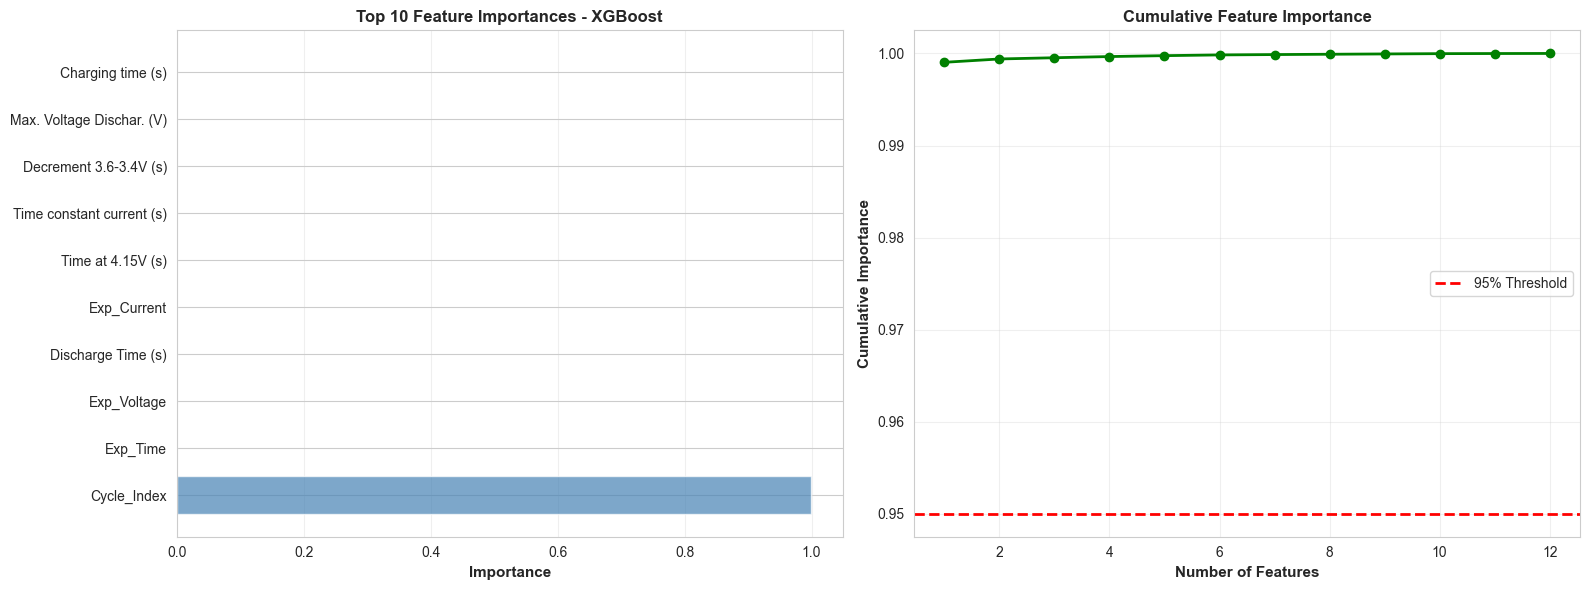


Top 5 Most Important Features:
  1. Cycle_Index: 0.9990
  2. Exp_Time: 0.0004
  3. Exp_Voltage: 0.0001
  4. Discharge Time (s): 0.0001
  5. Exp_Current: 0.0001


In [14]:
# 4. Feature importance (for tree-based models)
if best_model_name in ['Random Forest', 'XGBoost']:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Get feature importances
    if best_model_name == 'Random Forest':
        importances = best_model.feature_importances_
    else:  # XGBoost
        importances = best_model.feature_importances_
    
    # Create DataFrame for easier handling
    feature_importance_df = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    # Plot top 10 features
    top_n = min(10, len(feature_importance_df))
    top_features = feature_importance_df.head(top_n)
    
    ax = axes[0]
    ax.barh(range(len(top_features)), top_features['Importance'], color='steelblue', alpha=0.7)
    ax.set_yticks(range(len(top_features)))
    ax.set_yticklabels(top_features['Feature'])
    ax.set_xlabel('Importance', fontsize=11, fontweight='bold')
    ax.set_title(f'Top {top_n} Feature Importances - {best_model_name}', 
                 fontsize=12, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    # Cumulative importance
    ax2 = axes[1]
    cumulative_importance = feature_importance_df['Importance'].cumsum()
    ax2.plot(range(1, len(cumulative_importance) + 1), cumulative_importance, 
             marker='o', linewidth=2, markersize=6, color='green')
    ax2.axhline(y=0.95, color='r', linestyle='--', lw=2, label='95% Threshold')
    ax2.set_xlabel('Number of Features', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Cumulative Importance', fontsize=11, fontweight='bold')
    ax2.set_title('Cumulative Feature Importance', fontsize=12, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: feature_importance.png")
    plt.show()
    
    print(f"\nTop 5 Most Important Features:")
    for i, (_, row) in enumerate(top_features.head(5).iterrows(), 1):
        print(f"  {i}. {row['Feature']}: {row['Importance']:.4f}")
else:
    print(f"\nFeature importance not available for {best_model_name} (Linear Regression)")
    print("  Note: Feature importance is typically available for tree-based models")


## 11. Summary and Conclusions


In [15]:
print("=" * 80)
print("MODELING SUMMARY")
print("=" * 80)

print(f"\n📊 Dataset Information:")
print(f"  - Total samples: {len(df):,}")
print(f"  - Features: {len(feature_cols)}")
print(f"  - Training samples: {len(X_train):,}")
print(f"  - Testing samples: {len(X_test):,}")

print(f"\n🤖 Models Trained:")
for i, model_name in enumerate(models.keys(), 1):
    print(f"  {i}. {model_name}")

print(f"\n🏆 Best Model: {best_model_name}")
print(f"  - MAE:  {best_metrics['MAE']:.4f}")
print(f"  - MSE:  {best_metrics['MSE']:.4f}")
print(f"  - RMSE: {best_metrics['RMSE']:.4f}")
print(f"  - R²:   {best_metrics['R²']:.4f}")

print(f"\n💾 Saved Files:")
print(f"  - battery_health_model.pkl (Best model)")
print(f"  - feature_scaler.pkl (Feature scaler)")
print(f"  - model_info.json (Model metadata)")

print(f"\n📈 Visualizations Created:")
print(f"  - actual_vs_predicted_all_models.png")
print(f"  - best_model_detailed_analysis.png")
print(f"  - model_comparison_metrics.png")
if best_model_name in ['Random Forest', 'XGBoost']:
    print(f"  - feature_importance.png")

print(f"\n✅ Modeling completed successfully!")
print(f"\n📝 Next Steps:")
print(f"  1. Use the saved model for predictions on new data")
print(f"  2. Monitor model performance over time")
print(f"  3. Consider retraining with more data")
print(f"  4. Experiment with hyperparameter tuning")
print(f"  5. Consider ensemble methods combining multiple models")


MODELING SUMMARY

📊 Dataset Information:
  - Total samples: 15,064
  - Features: 12
  - Training samples: 12,051
  - Testing samples: 3,013

🤖 Models Trained:
  1. Linear Regression
  2. Random Forest
  3. XGBoost

🏆 Best Model: XGBoost
  - MAE:  1.2786
  - MSE:  2.7187
  - RMSE: 1.6488
  - R²:   1.0000

💾 Saved Files:
  - battery_health_model.pkl (Best model)
  - feature_scaler.pkl (Feature scaler)
  - model_info.json (Model metadata)

📈 Visualizations Created:
  - actual_vs_predicted_all_models.png
  - best_model_detailed_analysis.png
  - model_comparison_metrics.png
  - feature_importance.png

✅ Modeling completed successfully!

📝 Next Steps:
  1. Use the saved model for predictions on new data
  2. Monitor model performance over time
  3. Consider retraining with more data
  4. Experiment with hyperparameter tuning
  5. Consider ensemble methods combining multiple models
